# Face API Stats

### Server Logs

In [104]:
from glob import glob
import re
import time
import datetime
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [5]:
files = glob('./server_logs/*.log')

In [6]:
#log files
files

['./server_logs/2019_11_14_RD0003FF9BE514_api_docker.log']

In [7]:
def read(file):
    f = open(file, 'r')
    lines = f.readlines()
    f.close()
    # remove '\n' from end of lines
    return [line[:-1] for line in lines]

In [8]:
def parse_flask_logs(log):
    regex = '^(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d+Z) \[.+\] ([A-Z]+) in ([\w\d]+): (.+)$'
    match = re.search(regex, log)
    if match == None:
        return None
    else:
        #timestamp, type, name, data
        return match[1], match[2], match[3], match[4]

In [9]:
file_contents = list(map(read, files))

In [10]:
# is_match = lambda log: log != None
# list(map(lambda file: list(filter(is_match, map(parse_log, file))), file_contents))

In [11]:
# is_match = lambda log: log != None
# mapf(f)(x)
# mapf = lambda f: lambda x: list(map(f, x))
# filterf = lambda f: lambda x: list(filter(f, x))
# compose = lambda f, g: lambda x: g(f(x))
# mapf(compose(mapf(parse_log), filterf(is_match)))(file_contents)

In [12]:
def filter_map(f, ls):
    results = []
    for el in ls:
        result = f(el)
        if result != None:
            results.append(result)
    return results

parse_files = lambda file: filter_map(parse_flask_logs, file)
server_logs = list(map(parse_files, file_contents))

In [13]:
def flatten(ls):
    acc = []
    for el in ls:
        acc.extend(el)
    return acc

In [14]:
server_logs = flatten(server_logs)

In [15]:
server_logs_df = pd.DataFrame(server_logs, columns=['timestamp', 'log_type', 'log_name', 'data'])

In [17]:
#split api success status logs from proc time logs into two dataframes
id_succ_logs = server_logs_df[server_logs_df.apply(lambda x: '>>' in x['data'], axis=1)]
id_succ_logs = id_succ_logs.reset_index(drop=True)
proctimes = server_logs_df[server_logs_df.apply(lambda x: '$$' in x['data'], axis=1)]
proctimes = proctimes.reset_index(drop=True)

In [18]:
#clean up success logs
id_succ_logs['timestamp'] = pd.to_datetime(id_succ_logs['timestamp'])
id_succ_logs['data'] = id_succ_logs['data'].str.replace('>>', '')

In [19]:
def parse_proctimes(data):
    regex = '\$\$ (\w+) -- (\d+\.\d+)'
    match = re.search(regex, data)
    if match == None:
        return None
    else:
        return match[1], match[2]

In [20]:
#parse and clean up success logs
unzip = lambda x: list(zip(*x))
new_proctime_columns = proctimes['data'].map(lambda data: parse_proctimes(data))
proctimes['log_name'], proctimes['proc_time'] = unzip(new_proctime_columns)   
proctimes = proctimes.drop(columns='data')
proctimes['proc_time'] = proctimes['proc_time'].astype(float)
proctimes['timestamp'] = pd.to_datetime(proctimes['timestamp']) 

In [21]:
print('total number of requests: ' + str(len(id_succ_logs)))

total number of requests: 196


In [22]:
proctimes.groupby('log_name')['proc_time'].mean()

log_name
database_lookup          0.008361
face_detection_time      0.011919
face_recognition_time    0.153318
handle_identify          0.049914
process_image            0.043864
redis_lookup             0.001174
shape_predictor_time     0.003677
Name: proc_time, dtype: float64

In [23]:
ax = sns.countplot(x="data", data=id_succ_logs)

In [24]:
def plot_proctimes(field):
    p = proctimes[proctimes['log_name'] == field]
    plt.scatter(p['timestamp'].apply(lambda d: time.mktime(d.timetuple())), p['proc_time'], alpha=0.5)

In [25]:
plot_proctimes('handle_identify')

In [26]:
tmp = proctimes[proctimes['log_name'] == 'handle_identify']
tmp[tmp['proc_time'] > 0.15].mean()

proc_time    0.184594
dtype: float64

In [27]:
plot_proctimes('process_image')

In [28]:
tmp = proctimes[proctimes['log_name'] == 'process_image']
tmp[tmp['proc_time'] > 0.15].mean()

proc_time    0.176132
dtype: float64

In [29]:
plot_proctimes('redis_lookup')

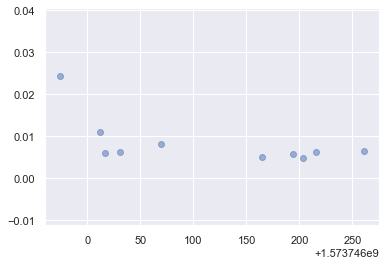

In [30]:
plot_proctimes('database_lookup')

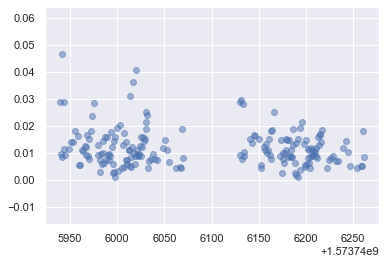

In [31]:
plot_proctimes('face_detection_time')

In [32]:
plot_proctimes('face_recognition_time')

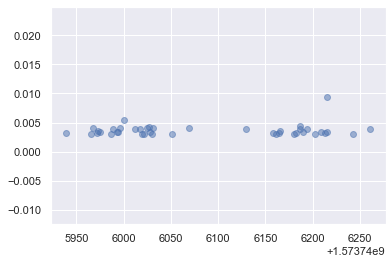

In [33]:
plot_proctimes('shape_predictor_time')

### Client Logs

In [34]:
with open('./client_logs/response.log') as client_logs:
    client_file_contents = client_logs.readlines()

In [35]:
def parse_client_logs(data):
    regex = '(\d+)--(\d+\.\d+)'
    match = re.search(regex, data)
    if match == None:
        return None
    else:
        return match[1], match[2]

In [114]:
client_logs_df = pd.DataFrame(client_file_contents, columns=['data'])
client_logs_df = client_logs_df.dropna()

In [116]:
unzip = lambda x: list(zip(*x))
new_columns = client_logs_df['data'].map(lambda data: parse_client_logs(data))
client_logs_df['timestamp_unix'], client_logs_df['proc_time'] = unzip(new_columns)  
client_logs_df = client_logs_df.drop(columns='data')
client_logs_df['timestamp_unix'] = client_logs_df['timestamp_unix'].astype(int)
client_logs_df['proc_time'] = client_logs_df['proc_time'].astype(float)

In [117]:
handle_identify_times = proctimes[proctimes['log_name'] == 'handle_identify']

In [125]:
total_network_latency = (client_logs_df['proc_time'].sum() - handle_identify_times['proc_time'].sum()) / len(handle_identify_times['proc_time'])

In [130]:
print('avg total network latency: %f seconds' % total_network_latency)

avg total network latency: 2.517541 seconds


In [133]:
plt.scatter(client_logs_df['timestamp_unix'], client_logs_df['proc_time'], alpha=0.5)